In [1]:
import pulp
import pandas as pd
import numpy as np
import matplotlib
from scipy.spatial.distance import euclidean, cdist
import matplotlib.pyplot as plt
import math
from collections import defaultdict

%matplotlib inline

### create data

In [2]:
AREA_SIZE = 200
NUM_SAMPLE = 108

In [3]:
list_point_id = list(range(1, NUM_SAMPLE + 1))

In [4]:
pid_coordinate_map = {}

for i in list_point_id:
    x, y = np.random.randint(0, AREA_SIZE), np.random.randint(0, AREA_SIZE)
    pid_coordinate_map[i] = (x, y)
    
coordinate_pid_map = {v: k for k, v in pid_coordinate_map.items()}

In [5]:
pid_pid_distance_map = {}

for i in list_point_id:
    for j in list_point_id:
        c1 = pid_coordinate_map[i]
        c2 = pid_coordinate_map[j]
        pid_pid_distance_map[i, j] = euclidean(c1, c2)

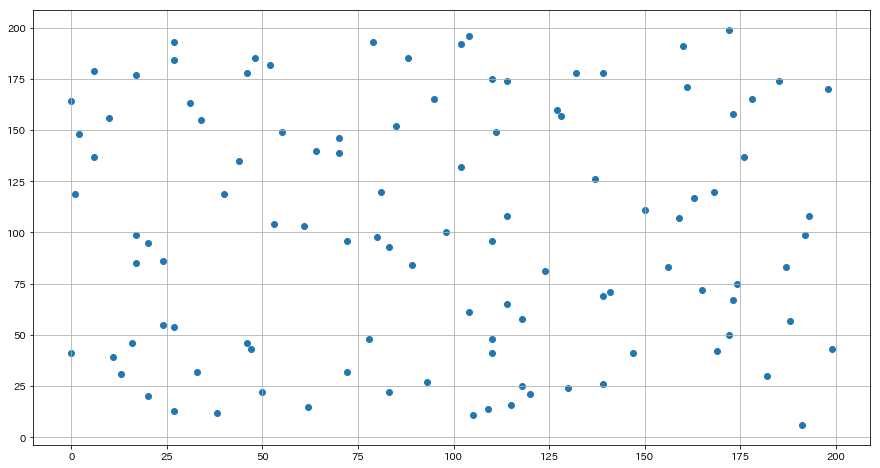

In [6]:
fig = plt.figure(figsize=(15, 8))
ax = fig.subplots()

list_x, list_y = [], []
for i in list_point_id:
    c = pid_coordinate_map[i]
    x, y = c[0], c[1]
    list_x.append(x)
    list_y.append(y)
    
ax.grid()
ax.scatter(x=list_x, y=list_y)

count    11664.000000
mean       105.477585
std         50.272121
min          0.000000
25%         66.708320
50%        103.532590
75%        143.565316
max        253.286399
dtype: float64

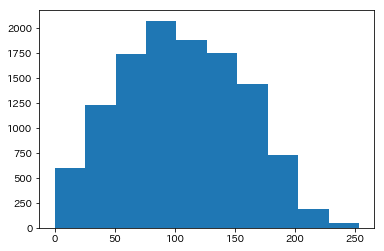

In [7]:
# 距離行列の分布
plt.hist(pid_pid_distance_map.values(), bins=10)

tmp = pd.Series(list(pid_pid_distance_map.values()))
tmp.describe()

### modeling

$$
    \min: \sum_{i, j}c_{i, j}\cdot x_{i, j} \\
    s,t : \sum_{j \in I, i \neq j}x_{i, j} = 1 - y_i \qquad (i \in I) \\
    \sum_{i \in I}y_i = ceil(\frac{|I|}{MaxClusterSample}) \\
    x_{i, j} \leq y_j \qquad (i, j \in I) \\
    MinClusterSample \cdot y_j \leq \sum_{i \in I, i \neq j}x_{i, j} \leq MaxClusterSample \cdot y_j \qquad  (j \in J) \\
    MinClusterDist \cdot z_{i, j} \leq c_{i, j} \qquad (i, j \in I) \\
    z_{i, j} \leq y_i, \quad z_{i, j} \leq y_j, \quad y_i + y_j \leq 1 + z_{i, j} \qquad (i, j \in I)
$$

In [40]:
model = pulp.LpProblem(sense=pulp.LpMinimize)
sense_map = {v: k for k, v in pulp.LpConstraintSenses.items()}

MIN_CLUSTER_DIST = 50
MIN_CLUSTER_SAMPLE = 5
MAX_CLUSTER_SAMPLE = 10
N_CLUSTER = math.ceil(NUM_SAMPLE/MAX_CLUSTER_SAMPLE)

In [41]:
pidpid_x_map = {}
pidpid_z_map = {}
for i in list_point_id:
    for j in list_point_id:
        if i == j:
            continue
        x = pulp.LpVariable(cat=pulp.LpBinary, name='x_%s_%s'%(i, j))
        pidpid_x_map[i, j] = x
        model.addVariable(x)

        z = pulp.LpVariable(cat=pulp.LpBinary, name='z_%s_%s'%(i, j))
        pidpid_z_map[i, j] = z
        model.addVariable(z)

pid_y_map = {}
for i in list_point_id:
    y = pulp.LpVariable(cat=pulp.LpBinary, name='y_%s'%i)
    pid_y_map[i] = y
    model.addVariable(y)

In [42]:
for i in list_point_id:
    xexpr = pulp.lpSum(pidpid_x_map[i, j] for j in list_point_id if i != j)
    constr = pulp.LpConstraint(e=xexpr + pid_y_map[i], sense=sense_map['='], rhs=1, name='point_must_be_in_cluster_%s'%i)
    model.addConstraint(constr)

In [43]:
yexpr = pulp.lpSum(pid_y_map[i] for i in list_point_id)
constr = pulp.LpConstraint(e=yexpr, sense=sense_map['='], rhs=N_CLUSTER, name='cluster_constraint')
model.addConstraint(constr)

In [44]:
for i in list_point_id:
    for j in list_point_id:
        if i == j:
            continue
        expr = pidpid_x_map[i, j] - pid_y_map[j]
        constr = pulp.LpConstraint(e=expr, sense=sense_map['<='], rhs=0, name='point_cluster_connection_%s_%s'%(i, j))
        model.addConstraint(constr)

In [45]:
for j in list_point_id:
    x_expr = pulp.lpSum(pidpid_x_map[i, j] for i in list_point_id if i != j)
    l_expr = MIN_CLUSTER_SAMPLE * pid_y_map[j] - x_expr
    l_constr = pulp.LpConstraint(e=l_expr, sense=sense_map['<='], rhs=0, name='min_cluster_sample_%s'%j)
    model.addConstraint(l_constr)
    
    r_expr = x_expr - MAX_CLUSTER_SAMPLE * pid_y_map[j]
    r_constr = pulp.LpConstraint(e=r_expr, sense=sense_map['<='], rhs=0, name='max_cluster_sample_%s'%j)
    model.addConstraint(r_constr)

In [46]:
for i in list_point_id:
    for j in list_point_id:
        if i==j:
            continue
        mcd_constr = pulp.LpConstraint(e=pidpid_z_map[i, j] * MIN_CLUSTER_DIST, 
                                                sense=sense_map['<='], 
                                                rhs=pid_pid_distance_map[i, j], name='min_cluster_dist_constr_%s_%s'%(i, j))
        
        zy_constr1 = pulp.LpConstraint(e=pidpid_z_map[i, j] - pid_y_map[i], sense=sense_map['<='], 
                                                rhs=0, name='z_y_connection1_%s_%s'%(i, j))
        
        zy_constr2 = pulp.LpConstraint(e=pidpid_z_map[i, j] - pid_y_map[j], sense=sense_map['<='], 
                                                rhs=0, name='z_y_connection2_%s_%s'%(i, j))

        zy_constr3 = pulp.LpConstraint(e=pid_y_map[i] + pid_y_map[j] - pidpid_z_map[i, j], sense=sense_map['<='],
                                                       rhs=1, name='z_y_connection3_%s_%s'%(i, j))
        
        model.addConstraint(mcd_constr)
        model.addConstraint(zy_constr1)
        model.addConstraint(zy_constr2)
        model.addConstraint(zy_constr3)

In [47]:
objective = pulp.lpSum(pid_pid_distance_map[i, j] * pidpid_x_map[i, j] for i in list_point_id for j in list_point_id if i != j)
model.setObjective(objective)

In [48]:
solver = pulp.PULP_CBC_CMD(maxSeconds=None, msg=1)

In [49]:
model.writeLP('./optimize_cluster.lp')
status = model.solve(solver=solver)
pulp.LpStatus[status]

'Optimal'

#### 最適化結果を格納

In [50]:
class OptimizeResult(object):
    def __init__(self, 
                       list_cluster_id,
                       pid_coordinate_map,
                       pid_clusterid_map, 
                       clusterid_pids_map,
                       min_cluster_dist):

        self.list_cluster_id = list_cluster_id
        self.pid_coordinate_map = pid_coordinate_map
        self.pid_clusterid_map = pid_clusterid_map
        self.clusterid_pids_map = clusterid_pids_map
        self.min_cluster_dist = min_cluster_dist

In [51]:
def get_optimize_result(list_point_id, pidpid_x_map, pid_coordinate_map):
    """最適化結果を格納する
    """
    list_cluster_id = []
    for i in list_point_id:
        v = round(pulp.value(pid_y_map[i]))
        if v == 1:
            list_cluster_id.append(i)

    pid_clusterid_map = {}
    for i in list_point_id:
        for j in list_point_id:
            if i == j:
                continue
            v = round(pulp.value(pidpid_x_map[i, j]))
            if v==1:
                pid_clusterid_map[i] = j
                
    clusterid_pids_map = defaultdict(list)

    for pid, cid in pid_clusterid_map.items():
        clusterid_pids_map[cid].append(pid)
        
    result = OptimizeResult(list_cluster_id=list_cluster_id,
                                       pid_coordinate_map=pid_coordinate_map,
                                       pid_clusterid_map=pid_clusterid_map, 
                                       clusterid_pids_map=clusterid_pids_map, 
                                       min_cluster_dist=MIN_CLUSTER_DIST)
    return result

### plot (MCD = 0)

In [27]:
def plot_result(optimize_result):
    """最適化結果を可視化する
    """
    cmap = plt.get_cmap('tab10')
    fig = plt.figure(figsize=(15, 8))
    ax = fig.subplots()
    ax.grid()

    cmap = plt.get_cmap('tab10')
    for i, (cid, pids) in enumerate(optimize_result.clusterid_pids_map.items()):
        cx, cy = optimize_result.pid_coordinate_map[cid]
        color = cmap(i)
        ax.scatter(x=cx, y=cy, c=color, s=100)

        list_x, list_y = [], []
        for pid in pids:
            px, py = optimize_result.pid_coordinate_map[pid]
            list_x.append(px)
            list_y.append(py)

        ax.scatter(x=list_x, y=list_y, c=color)

In [28]:
result = get_optimize_result(list_point_id=list_point_id, pidpid_x_map=pidpid_x_map, pid_coordinate_map=pid_coordinate_map)

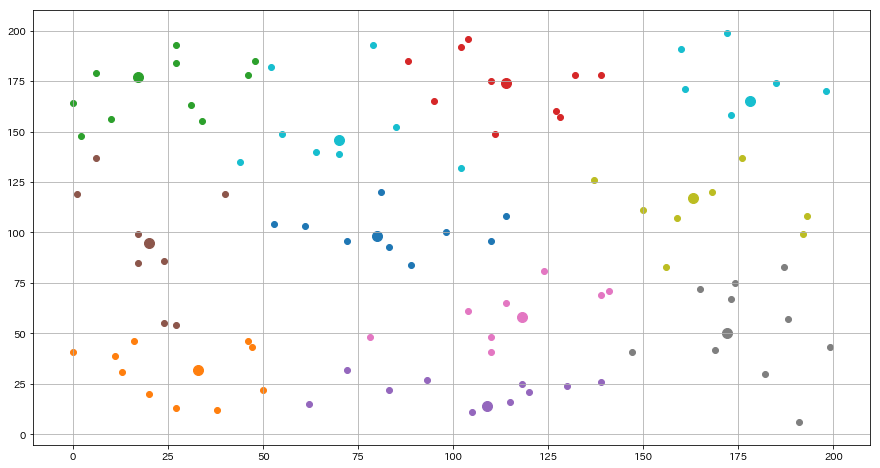

In [29]:
plot_result(result)

### plot (MCD = 50)

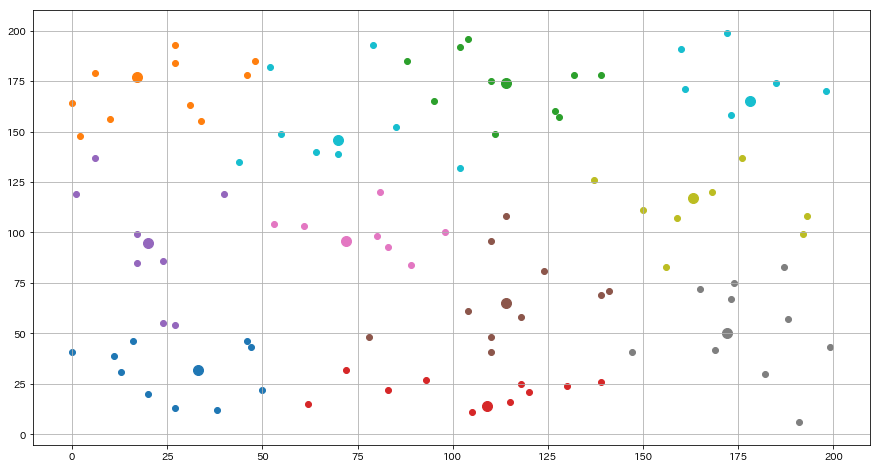

In [52]:
result = get_optimize_result(list_point_id=list_point_id, pidpid_x_map=pidpid_x_map, pid_coordinate_map=pid_coordinate_map)
plot_result(result)